# Triton Kernel

In [1]:
!pip install triton

In [2]:
import torch
import triton
import triton.language as tl

In [3]:
batch_size=10
embedding_dim=512

In [4]:
X=torch.randn(batch_size,embedding_dim).to('cuda')
print(X.shape)

torch.Size([10, 512])


### Triton kernel

In [5]:
@triton.jit
def layer_norm_kernel(
    input_ptr,
    output_ptr,
    weight_ptr,
    bias_ptr,
    n_rows,
    n_cols,
    eps,
    BLOCK_SIZE:tl.constexpr
):
  # which row to pick
  row_id=tl.program_id(0)#0 to 9 becuase we have 10 rows
  # Bound check
  if(row_id>=n_rows):
    return

  # starting pointer of the row
  row_start_ptr=input_ptr+row_id*n_cols

  # col offsets
  col_offsets=tl.arange(0,BLOCK_SIZE)
  mask=col_offsets<n_cols

  # load all the row
  input_ptr=row_start_ptr+col_offsets
  row = tl.load(input_ptr, mask=mask, other=0.0)

  # calcualte mean
  row_sum=tl.sum(row,axis=0)
  mean=row_sum/n_cols

  # variance
  row_minus_mean = row - mean
  # [0.5-0.098, -1.2-0.098, ..., -0.3-0.098]
  # = [0.402, -1.298, ..., -0.398]

  row_var = tl.sum(row_minus_mean * row_minus_mean, axis=0) / n_cols
  rstd = 1.0 / tl.sqrt(row_var + eps)
  normalized = row_minus_mean * rstd

  weight = tl.load(weight_ptr + col_offsets, mask=mask)
  # Gamma values (usually initialized to 1.0)

  bias = tl.load(bias_ptr + col_offsets, mask=mask)
  # Beta values (usually initialized to 0.0)

  output = normalized * weight + bias
  # Final layer norm output
  output_row_start_ptr = output_ptr + row_id * n_cols
  output_ptr = output_row_start_ptr + col_offsets

  tl.store(output_ptr, output, mask=mask)





### Python Wrapper

In [6]:
def triton_layerNorm_kernel(X, weight, bias, eps=1e-5):
    """
    X: (batch_size, embedding_dim)
    weight: (embedding_dim,)  # gamma
    bias: (embedding_dim,)    # beta
    """

    batch_size, embedding_dim = X.shape
    output = torch.empty_like(X)

    BLOCK_SIZE = triton.next_power_of_2(embedding_dim)
    grid = (batch_size,)

    layer_norm_kernel[grid](
        X,
        output,
        weight,
        bias,
        batch_size,
        embedding_dim,
        eps,
        BLOCK_SIZE=BLOCK_SIZE   # must match @triton.jit arg name
    )

    return output


### data

In [7]:
import torch.nn as nn

pytorch_ln = nn.LayerNorm(embedding_dim).cuda()  # embedding_dim = 512
pytorch_output = pytorch_ln(X)

In [8]:
batch_size = 64  # Small for testing, badha sakte ho for real perf
embedding_dim = 4096
X = torch.randn(batch_size, embedding_dim, device='cuda')
weight = torch.ones(embedding_dim, device='cuda')
bias = torch.zeros(embedding_dim, device='cuda')

In [9]:
triton_out = triton_layerNorm_kernel(X, weight, bias)
pytorch_out = nn.LayerNorm(embedding_dim).cuda()(X)  # But set same weight/bias if needed
print(torch.allclose(triton_out, pytorch_out, atol=1e-4))  # Should be True

True


In [10]:
import timeit

# Triton
def triton_time():
    triton_layerNorm_kernel(X, weight, bias)
    torch.cuda.synchronize()

triton_ms = min(timeit.repeat(triton_time, number=1, repeat=100)) * 1000  # ms
print(f"Triton: {triton_ms:.4f} ms")

# PyTorch
pytorch_ln = nn.LayerNorm(embedding_dim).cuda()
pytorch_ln.weight.data = weight
pytorch_ln.bias.data = bias

def pytorch_time():
    pytorch_ln(X)
    torch.cuda.synchronize()

pytorch_ms = min(timeit.repeat(pytorch_time, number=1, repeat=100)) * 1000
print(f"PyTorch: {pytorch_ms:.4f} ms")

# Speedup: pytorch_ms / triton_ms

Triton: 0.0460 ms
PyTorch: 0.0467 ms


In [11]:
from torch.profiler import profile, record_function, ProfilerActivity

# Triton
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof_triton:
    with record_function("triton_layerNorm_kernel"):
        for _ in range(100):  # Multiple runs for avg
            triton_out = triton_layerNorm_kernel(X, weight, bias)

prof_triton.export_chrome_trace("triton_profile.json")  # View in chrome://tracing
print(prof_triton.key_averages().table(sort_by="cuda_time_total", row_limit=10))

# PyTorch
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof_pytorch:
    with record_function("pytorch_layer_norm"):
        for _ in range(100):
            pytorch_out = pytorch_ln(X)

prof_pytorch.export_chrome_trace("pytorch_profile.json")
print(prof_pytorch.key_averages().table(sort_by="cuda_time_total", row_limit=10))

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    triton_layerNorm_kernel         0.00%       0.000us         0.00%       0.000us       0.000us      10.496ms      1278.75%      10.496ms      10.496ms             1  
          layer_norm_kernel         0.00%       0.000us         0.00%       0.000us       0.000us     820.806us       100.00%     820.806us       8.208us           100  
    triton_layerNorm_kernel        51.62%      12.425ms        99.92%      24.048ms      24.048ms       0.000us         0.00%       0.000us       0.0

layer-norm-performance:
         N      Triton     PyTorch
0    256.0  211.777546  135.006557
1    512.0  331.472152  335.529740
2   1024.0  338.904346  327.772546
3   2048.0  341.265716  266.483235
4   4096.0  338.603874  245.906007
5   8192.0  345.267922  246.278255
6  16384.0  349.585677  244.647532
7  32768.0   56.785404  244.393935


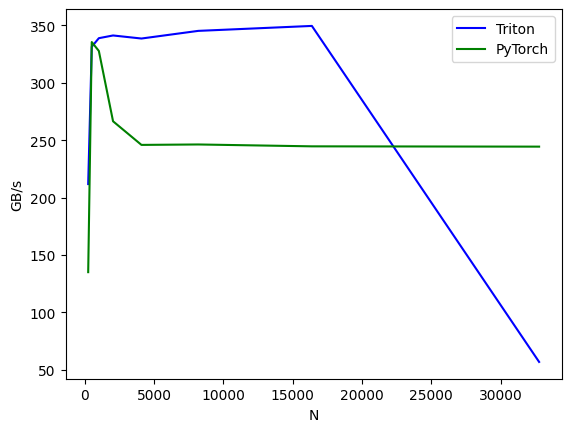

In [17]:
import triton.testing as testing
import torch.nn as nn  # For PyTorch LayerNorm

@testing.perf_report(
    testing.Benchmark(
        x_names=['N'],  # embedding_dim vary
        x_vals=[256, 512, 1024, 2048, 4096, 8192, 16384, 32768],  # Small to large
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'PyTorch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',  # Bandwidth metric
        plot_name='layer-norm-performance',
        args={'M': 4096}  # Batch size fixed large
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda')
    weight = torch.ones(N, device='cuda')
    bias = torch.zeros(N, device='cuda')
    eps = 1e-5

    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_layerNorm_kernel(x, weight, bias))
    if provider == 'torch':
        ln = nn.LayerNorm(N).cuda()
        ln.weight.data = weight
        ln.bias.data = bias
        ms = triton.testing.do_bench(lambda: ln(x))

    # Direct compute GB/s (approx 3x bytes for read/write in layer norm)
    gbps_value = (x.numel() * x.element_size() * 3 * 1e-9) / (ms * 1e-3)
    return gbps_value

benchmark.run(save_path='.', print_data=True)